<a href="https://colab.research.google.com/github/MohammadYehya/SegmentAnythingModel_SAM/blob/main/SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM 2 via HuggingFace Demo (Colab/PyPI) 🧪

This notebook uses the HuggingFace‑published version of SAM 2, so you don’t need to manually clone or download checkpoints.

In [1]:
# Install dependencies
!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -e ".[notebook]"


Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.1 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=fef90f0d4c35542b2d39014c9c482a25d297f16cb8f6705eb7e6a590b419df6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mwtrp8tt/wheels/9e/fa

In [33]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from google.colab import files

In [34]:
# Load model from HuggingFace
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2.1-hiera-large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictor.model.to(device)
print("Loaded SAM2, device =", device)

Loaded SAM2, device = cuda


In [35]:
# Upload image (Colab) or load locally
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Loaded image", img_path, "shape", img.shape)
predictor.set_image(img)
# h, w, _ = img.shape
# predictor.image_size = (h, w)

Saving test2.jpg to test2 (6).jpg
Loaded image test2 (6).jpg shape (300, 450, 3)


In [39]:
def overlay_mask_translucent(img, mask, color=(0,255,0), alpha=0.4):
    overlay = img.copy()
    mask_bool = mask.astype(bool)
    overlay[mask_bool] = np.array(color, dtype=np.uint8)
    blended = img.copy()
    blended[mask_bool] = (img[mask_bool] * (1 - alpha) + overlay[mask_bool] * alpha).astype(np.uint8)
    return blended


Using prompt point (x,y): [112, 150]
Mask generated, score = 0.43419763


(np.float64(-0.5), np.float64(449.5), np.float64(299.5), np.float64(-0.5))

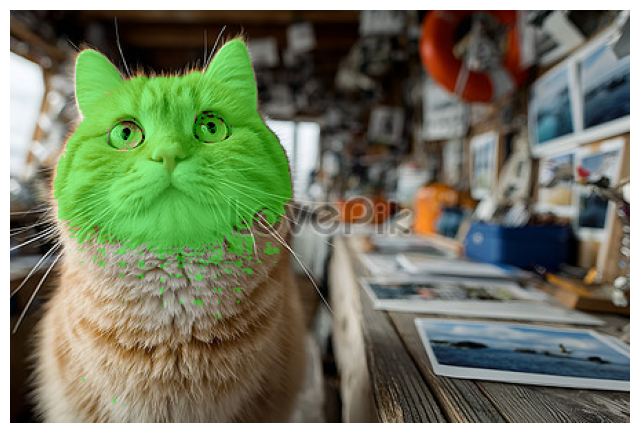

In [42]:
# Example: segmentation by point prompt
point = [int(img.shape[1]//4), int(img.shape[0]//2)]  # center by default
print("Using prompt point (x,y):", point)
masks, scores, _ = predictor.predict(
    point_coords = np.array([point]),
    point_labels = np.array([1]),  # 1 = foreground
    multimask_output = True
)
mask = masks[0]
print("Mask generated, score =", scores[0])
overlay = overlay_mask_translucent(img, mask)
plt.figure(figsize=(8,8)); plt.imshow(overlay); plt.axis('off')

(np.float64(-0.5), np.float64(449.5), np.float64(299.5), np.float64(-0.5))

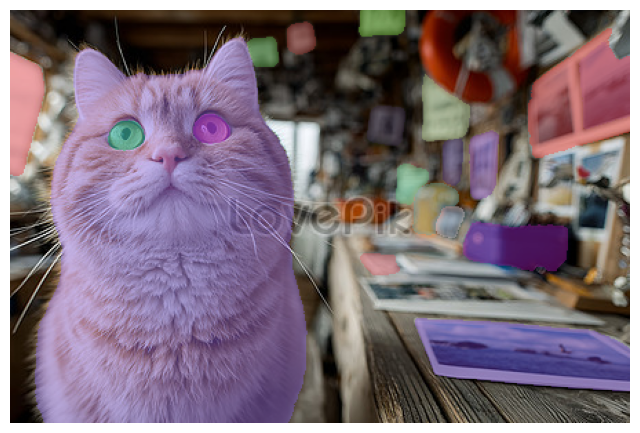

In [48]:
mask_generator = SAM2AutomaticMaskGenerator(predictor.model)
all_masks = mask_generator.generate(img)

# Visualize masks
overlay = img.copy()
for m in all_masks:
    mask = m['segmentation']
    color = np.random.randint(0, 255, size=3)
    overlay = overlay_mask_translucent(overlay, mask, color)

plt.figure(figsize=(8,8)); plt.imshow(overlay); plt.axis("off")